In [7]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import networkx as nx # import the library
import plotly.graph_objects as go
import community as community_louvain

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt

In [11]:
# ---- STEP 1: Load your data ----
metab_path = pd.read_excel("data_triangle/metab_pathways_sign_correlation.xlsx") # correlation metabolites and pathways
mo_metab_b = pd.read_excel("data_triangle/metab_corr_bacteria.xlsx")             # correlation metabolites and bacteria
mo_metab_e = pd.read_excel("data_triangle/metab_corr_eukarya.xlsx")              # correlation metabolites and eukaryota
path_mo_b = pd.read_excel("data_triangle/MO_corr_path_bacteria.xlsx")            # correlation pathways and bacteria
path_mo_e = pd.read_excel("data_triangle/MO_corr_path_fungi.xlsx")               # correlation pathways and eukaryota
bact_in_time = pd.read_excel("data_triangle/bacteria_in_time.xlsx")              # enrichment bacteria in time
fungi_in_time = pd.read_excel("data_triangle/eukaryotes_in_time.xlsx")           # enrichment fungi in time

In [12]:
# change column names in order to have similar names
metab_path.columns = ["Metabolite", "Pathway", "Correlation"]
mo_metab_b.columns = ["Metabolite", "Microorganism", "Correlation"]
mo_metab_e.columns = ["Metabolite", "Microorganism", "Correlation"]
path_mo_b.columns = ["Microorganism", "Pathway", "Correlation"]
path_mo_e.columns = ["Microorganism", "Pathway", "Correlation"]
fungi_in_time.columns = ["Microorganism", "enrich_group"]
bact_in_time.columns = ["Microorganism", "enrich_group"]

In [13]:
#micro_met_t.columns.tolist()
# df.columns.tolist()
time_0 = fungi_in_time['enrich_group'].unique()
time_0

array(['T0', 'T1', 'T2', 'T3'], dtype=object)

**Fungi Network analysis**

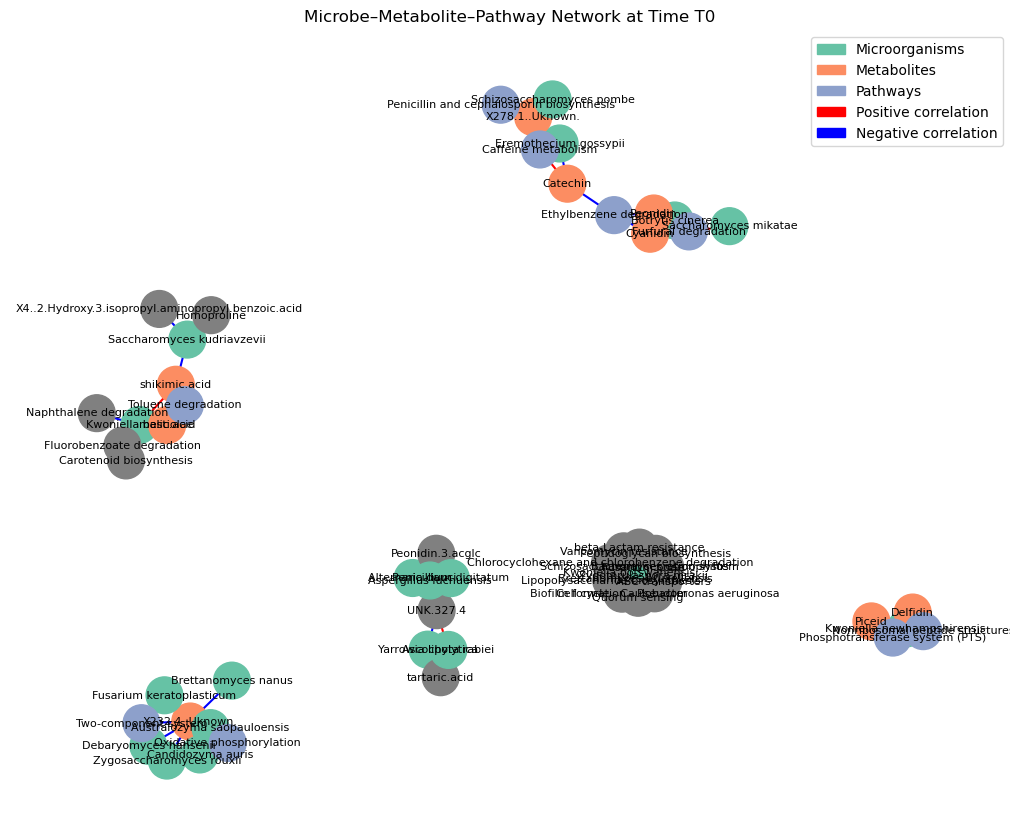

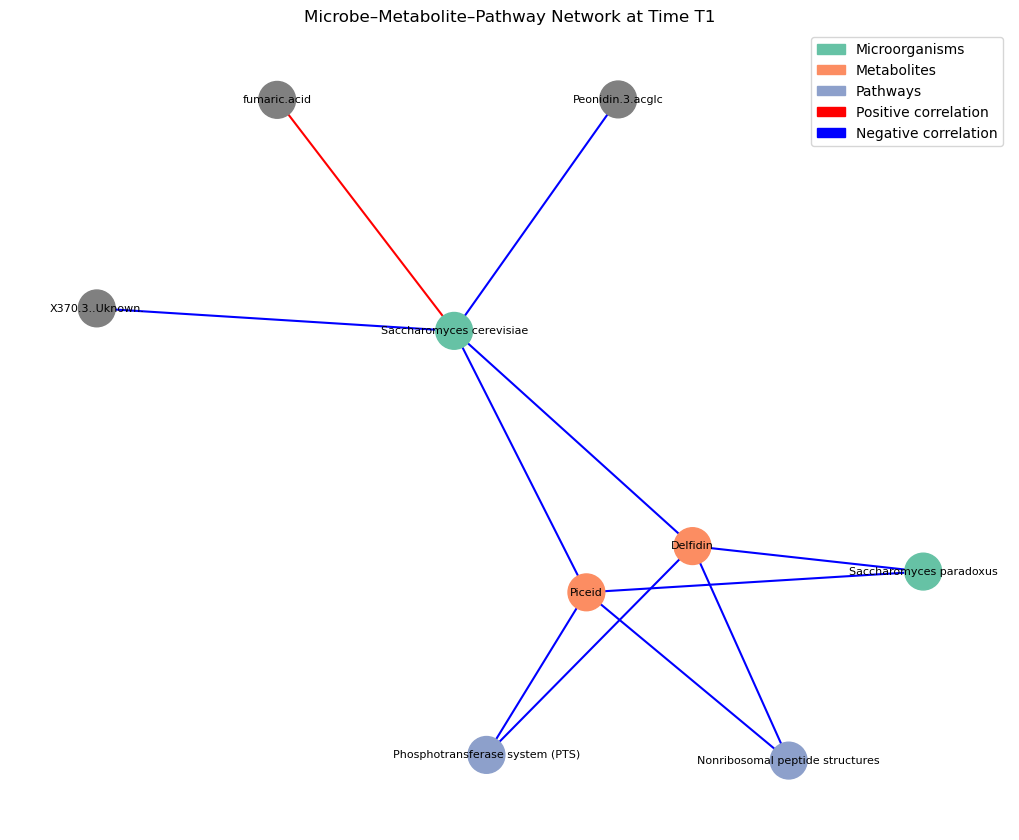

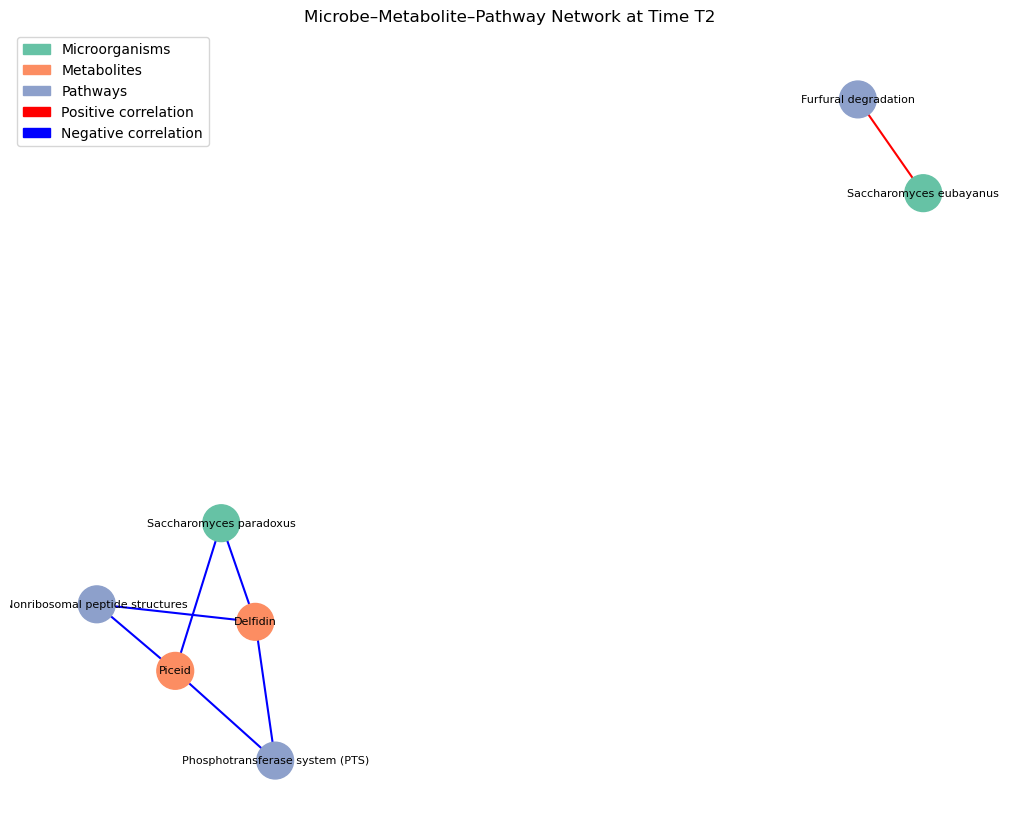

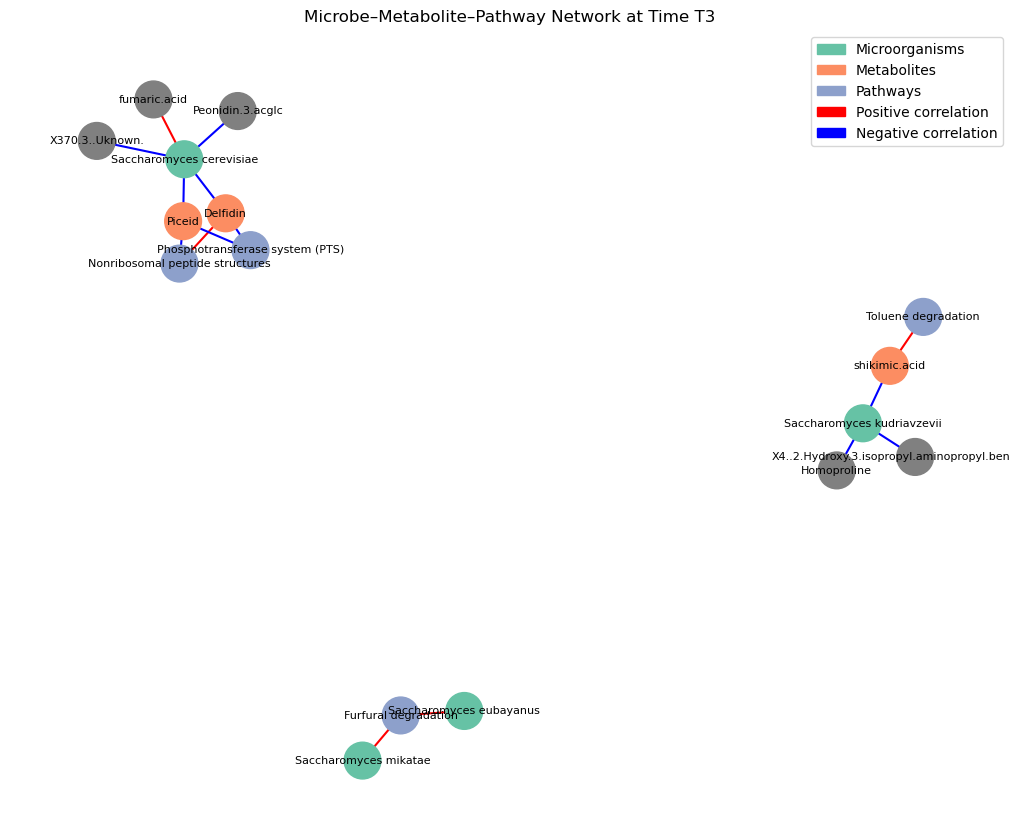

In [21]:
import os
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community_louvain


# Create output directory
output_dir = "networks_fungi" # creation of the directory for the fungi kingdom
os.makedirs(output_dir, exist_ok=True) #
output_hubs_dir = os.path.join(output_dir, "hubs")
os.makedirs(output_hubs_dir, exist_ok=True)
output_communities_dir = os.path.join(output_dir, "communities")
os.makedirs(output_communities_dir, exist_ok=True)

# Unique time points
time_0 = fungi_in_time['enrich_group'].unique()

for t in time_0: # Loop over the different time points
    # Microbes present at this time
    fungi_t = fungi_in_time[fungi_in_time['enrich_group'] == t] # take the fungi that are present at that specific time
    
    # Merge abundance with correlations
    micro_met_t = mo_metab_e.merge(fungi_t, on='Microorganism') # merge the microorganisms in the metabolite correlation table

    # Merge metabolites with correlations of pathways-metab table
    metab_path_t = micro_met_t.merge(metab_path, on='Metabolite')

    # Merge Microorganisms with correlations of pathways-mo table
    path_mo_e_t = path_mo_e.merge(fungi_t, on='Microorganism')
    
    # Collect edges
    edges = []
    edge_colors = []  # to store color based on correlation sign

    # Microorganism–Metabolite edges
    for _, row in micro_met_t.iterrows():
        edges.append((row['Microorganism'], row['Metabolite'], abs(row['Correlation'])))
        edge_colors.append('red' if row['Correlation'] > 0 else 'blue')

    # Metabolite–Pathway edges
    for _, row in metab_path_t.iterrows():
        edges.append((row['Metabolite'], row['Pathway'], abs(row['Correlation_y'])))
        edge_colors.append('red' if row['Correlation_y'] > 0 else 'blue')

    # Pathway–Microorganism edges
    for _, row in path_mo_e_t.iterrows():
        edges.append((row['Pathway'], row['Microorganism'], abs(row['Correlation'])))
        edge_colors.append('red' if row['Correlation'] > 0 else 'blue')

    # Create graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges)

    # Define node colors by type
    node_colors = []
    for node in G.nodes():
        if node in fungi_in_time['Microorganism'].values:
            node_colors.append('#66c2a5')  # greenish for Microorganisms
        elif node in metab_path['Metabolite'].values:
            node_colors.append('#fc8d62')  # orange for Metabolites
        elif node in metab_path['Pathway'].values:
            node_colors.append('#8da0cb')  # blue/purple for Pathways
        else:
            node_colors.append('gray')

    # Draw network
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        edge_color=edge_colors,
        node_size=700,
        font_size=8,
        width=1.5
    )

    # Add title and legend
    plt.title(f"Microbe–Metabolite–Pathway Network at Time {t}")

    # Create a manual legend
    import matplotlib.patches as mpatches
    legend_elements = [
        mpatches.Patch(color='#66c2a5', label='Microorganisms'),
        mpatches.Patch(color='#fc8d62', label='Metabolites'),
        mpatches.Patch(color='#8da0cb', label='Pathways'),
        mpatches.Patch(color='red', label='Positive correlation'),
        mpatches.Patch(color='blue', label='Negative correlation'),
    ]
    plt.legend(handles=legend_elements, loc='best')

    # Save and show
    filename = os.path.join(output_dir, f"network_time_{t}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Hub detection (Degree centrality) ---
    degree_centrality = nx.degree_centrality(G)

    # Separate hubs by node type
    microbe_hubs = {n: c for n, c in degree_centrality.items() if n in fungi_in_time['Microorganism'].values}
    metabolite_hubs = {n: c for n, c in degree_centrality.items() if n in metab_path['Metabolite'].values}
    pathway_hubs = {n: c for n, c in degree_centrality.items() if n in metab_path['Pathway'].values}

    # Convert to DataFrames and save
    def save_hubs_dict(hubs_dict, node_type):
        df = pd.DataFrame(hubs_dict.items(), columns=[node_type, 'DegreeCentrality'])
        df = df.sort_values(by='DegreeCentrality', ascending=False)
        df.to_csv(os.path.join(output_hubs_dir, f"{node_type}_hubs_time_{t}.csv"), index=False)

    save_hubs_dict(microbe_hubs, 'Microorganism')
    save_hubs_dict(metabolite_hubs, 'Metabolite')
    save_hubs_dict(pathway_hubs, 'Pathway')

    # --- Community detection using Louvain ---
    partition = community_louvain.best_partition(G)

    community_df = pd.DataFrame(partition.items(), columns=['Node', 'Community'])
    community_df.to_csv(os.path.join(output_communities_dir, f"communities_time_{t}.csv"), index=False)

